### 1. Import dependencies

In [45]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [46]:
import torch
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import intel_pytorch_extension as ipex

In [47]:
torch.__version__

'1.7.0a0+e85d494'

### 2. Create PyTorch data generators

In [70]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('data/validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=128,
                                shuffle=True, num_workers=0),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=128,
                                shuffle=False, num_workers=0)
}

### 3. Create the network

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(ipex.DEVICE)

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [78]:
import time

### 4. Train the model

In [81]:
def train_model(model, criterion, optimizer, num_epochs=6):
    since= time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        #model = model.to(ipex.device)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            model = model.to(ipex.DEVICE)
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                inputs = inputs.to(ipex.DEVICE)
                labels = labels.to(ipex.DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [82]:
model_trained = train_model(model, criterion, optimizer, num_epochs=6)

Epoch 1/6
----------
train loss: 0.1900, acc: 0.9236
validation loss: 0.2307, acc: 0.8950
Epoch 2/6
----------
train loss: 0.1615, acc: 0.9323
validation loss: 0.2383, acc: 0.8850
Epoch 3/6
----------
train loss: 0.1414, acc: 0.9395
validation loss: 0.2139, acc: 0.9150
Epoch 4/6
----------
train loss: 0.1400, acc: 0.9481
validation loss: 0.2250, acc: 0.9000
Epoch 5/6
----------
train loss: 0.1531, acc: 0.9438
validation loss: 0.1966, acc: 0.9350
Epoch 6/6
----------
train loss: 0.1228, acc: 0.9553
validation loss: 0.2078, acc: 0.9150
Training complete in 2m 56s


### 5. Save and load the model

In [21]:
torch.save(model_trained.state_dict(), '/home/u48334/Keras-PyTorch-AvP-transfer-learning/weights.h5')

In [22]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('/home/u48334/Keras-PyTorch-AvP-transfer-learning/weights.h5'))

<All keys matched successfully>

### 6. Make predictions on sample test images

In [23]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [24]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [25]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

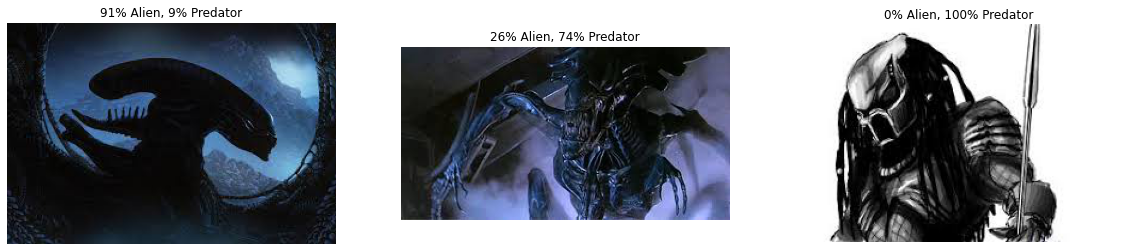

In [26]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)